In [1]:
import numpy as np
import matplotlib.pyplot as plt
from random import randint, random
from matplotlib.animation import FuncAnimation
from random import randint, random
import matplotlib.animation as animation

%matplotlib ipympl

# Test Build of the Cellular Potts Model

In [24]:
# --- Parameters ---
#L = 10            # Lattice size (100x100 grid)
n_cells = 2        # Number of cells
J = 1             # Boundary energy term
T = 1           # "Temperature" (controls acceptance probability)
target_area = (L*L) / n_cells
lambda_area = 0.2  # Strength of area constraint
steps = 500000      # Number of Monte Carlo steps

# --- Initialization ---
# Create a lattice assigning random cell IDs
lattice = np.random.randint(0, n_cells, (L, L))


In [25]:
lattice

array([[0, 1, 1, 1, 0, 0, 0, 1, 1, 0],
       [0, 1, 0, 0, 1, 1, 1, 0, 1, 0],
       [1, 0, 0, 0, 0, 1, 1, 0, 0, 1],
       [0, 0, 1, 1, 1, 1, 1, 0, 0, 1],
       [0, 0, 1, 0, 0, 0, 1, 1, 1, 0],
       [0, 1, 0, 0, 0, 1, 1, 1, 0, 0],
       [0, 1, 1, 1, 0, 0, 0, 1, 1, 0],
       [0, 1, 1, 0, 0, 1, 1, 0, 1, 0],
       [1, 0, 1, 0, 0, 0, 1, 1, 0, 1],
       [1, 0, 0, 1, 1, 1, 1, 0, 0, 1]])

In [19]:
class CellularPottsModel:
    def __init__(self, n_cells, J, T, lam, 
                 lattice: np.array=None,
                 object_volumes: list[float]=None, L=None, rows=None, cols=None):
        self.L = L
        if L is None and (rows is not None and cols is not None):
            self.rows = rows
            self.cols = cols
        else:
            self.rows = L
            self.cols = L 
        
        self.n_cells = n_cells
        self.J = J
        self.T = T
        self.lam = lam
        self.object_volumes = object_volumes  # None or a list of target volume for each cell
        if lattice is None:
            self.lattice = np.random.randint(0, self.n_cells, (self.rows, self.cols))
        else:
            self.lattice = lattice
        self.V = self.set_object_volumes()
        self.volume_unit = 1

    #-------------------------------------------------------
    
    # SET UP FOR PRACTICALITIES, COEFFICIENTS AND TYPE/CELL BASED CONSTANTS: 

    def neighbors_2d(self, point_index):
        """
        Returns a list of the neighbors (periodic boundaries) for element (i, j).
        """
        i, j = point_index
        neighbors = [
                    ((i - 1) % self.rows, (j - 1) % self.cols), 
                    ((i - 1) % self.rows, j),
                    ((i - 1) % self.rows, (j + 1) % self.cols),
                    (i, (j - 1) % self.cols),
                    (i, (j + 1) % self.cols),
                    ((i + 1) % self.rows, (j - 1) % self.cols),
                    ((i + 1) % self.rows, j),
                    ((i + 1) % self.rows, (j + 1) % self.cols),
                    ]
        return neighbors
    
    def cell_type(self, point_index):
        pass

    def set_object_volumes(self):
        V = {}  # volume dict
        if self.object_volumes is None:
            for i in range(self.n_cells): # for each cell identifier
                V[i] = (self.rows * self.cols) / self.n_cells
        elif self.V is not None:
            for i, vol in enumerate(self.object_volumes):
                V[i] = vol
        return V

    def adhesion_coefficient_J(self):
        pass


    #-------------------------------------------------------

    # HAMILTONIAN CALCULATION LOGIC
    
    def adhesion_term(self, 
                      point_index, 
                      point_value, 
                      grid):
        """
        Calculate the adhession term.
        """
        neighbors = self.neighbors_2d(point_index)
        neighbor_values = np.array([grid[r, c] for r, c in neighbors])
        diffs = (neighbor_values != point_value).astype(int) * self.J  # find where the neighbor isn't same as point, 
                                                               # TODO: Let J be function of type
        H_adh = diffs.sum()
        return H_adh
    
    def volume_term(self, 
                    point_value, 
                    grid,
                    new: bool=None, 
                    source: bool=None):
        """
        Calculate the volume term.
        """
        target_vol = self.V.get(point_value)
        if new and not source: # if we were to change the point, and the point we are looking at is the target point
            current_vol = np.sum(grid == point_value) - self.volume_unit
        elif new and source: # if we were to change the point, and the point we are looking at is the target point
            current_vol = np.sum(grid == point_value) + self.volume_unit
        else:
            current_vol = np.sum(grid == point_value)
        H_vol = (current_vol - target_vol)**2
        return H_vol
    

    def calculate_H(self,
                    source_point, target_point, 
                    target_point_index, grid, 
                    new: bool):
        """
        Calculate the the Hamiltonian (total energy).
        """
        if new:  
            H = (
                self.adhesion_term(point_index=target_point_index, point_value=source_point, grid=grid) + 
                self.lam *
                    (
                    self.volume_term(point_value=target_point, grid=grid, new=new, source=False) + 
                    self.volume_term(point_value=target_point, grid=grid, new=new, source=True)
                    )
                )
        else:
            H = (
                self.adhesion_term(point_index=target_point_index, point_value=target_point, grid=grid) + 
                self.lam *
                    (
                    self.volume_term(point_value=target_point, grid=grid, new=new, source=False) + 
                    self.volume_term(point_value=target_point, grid=grid, new=new, source=True)
                    )
                )
        return H

    #---------------------------------------------------------

    def step(self, grid):
        source_point_index = [np.random.randint(self.rows), np.random.randint(self.cols)]
        source_point = grid[source_point_index[0], source_point_index[1]]
        target_point_index = self.neighbors_2d(source_point_index)[np.random.randint(8)]
        target_point = grid[target_point_index[0], target_point_index[1]]

        if source_point == target_point:
            pass  # Skip if the target and source are the same cell
        else: 
            H_old = self.calculate_H(source_point=source_point,
                                     target_point=target_point,
                                     target_point_index=target_point_index, 
                                     grid=grid,
                                     new=False)
            
            H_new = self.calculate_H(source_point=source_point,
                                     target_point=target_point,
                                     target_point_index=target_point_index, 
                                     grid=grid,
                                     new=True)
            
            dH = H_new - H_old

            if dH < 0 or np.random.random() < np.exp(-dH / self.T):
                grid[target_point_index] = source_point

    def run(self):
        grid = self.lattice.copy()
        fig, ax = plt.subplots()
        img = ax.imshow(grid, cmap="viridis", interpolation="nearest")

        def update(frame):
            self.step(grid)
            img.set_data(grid)
            ax.set_title(f"Step {frame}")
            return [img]

        anim = FuncAnimation(
            fig, update, frames=10000, interval=0.1, blit=True, repeat=False
        )

        plt.show()
        return anim
            
    
        

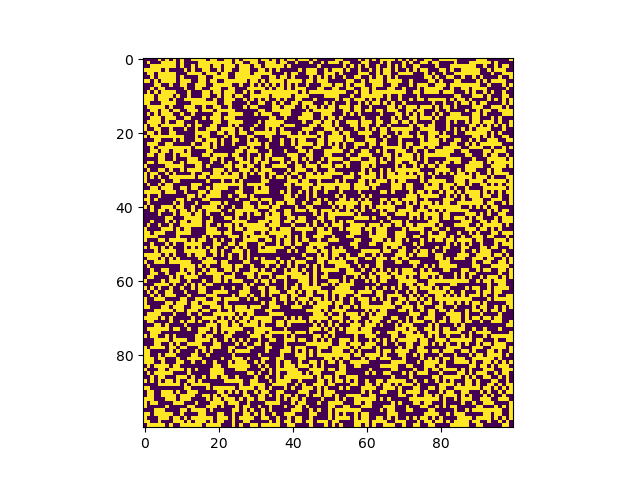

In [20]:
cpm = CellularPottsModel(n_cells=2, J=10, T=1, lam=0, L=100)
a=cpm.run()
a